# **AML Challenge: Model Stitching**

In [ ]:
# @title
from PIL import Image
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms

from sentence_transformers import SentenceTransformer, util
from diffusers import AutoencoderKL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Downloading the Text Encoder**

In [ ]:
print("🫁 Downloading the model...")
text_encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

### **Demo for the Text Encoder:**

In [ ]:
text = "A cat is hiding under the table"

# We obtain the "embedding vector" using the encode() function:
emb = text_encoder.encode(text, convert_to_tensor=True, show_progress_bar=False)

# This is only for clarity:
preview = emb.tolist()[:3] + ["..."] + emb.tolist()[-3:]
print(f"The embedding looks like this: {preview}")

# This is the shape of our embedding:
print(f"The shape of the embedding is: {emb.shape}")

## **Downloading the VAE**

In [ ]:
print("🫁 Downloading VAE from Hugging Face...")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)

### **Demo for the VAE:**

In [ ]:
IMG_URL = "https://images.unsplash.com/photo-1574144611937-0df059b5ef3e?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=764"
img = Image.open(urlopen(IMG_URL)).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((256, 256)), # --> keep this size fixed
    # The VAE works also for 512x512, but it will require more compute
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
img_tensor = preprocess(img).unsqueeze(0).to(device)


# Encode --> latent
with torch.no_grad():
    latents = vae.encode(img_tensor).latent_dist.sample() * 0.18215
print("Latent shape:", latents.shape)

# Decode --> reconstruct
with torch.no_grad():
    recon = vae.decode(latents / 0.18215).sample

recon = (recon.clamp(-1, 1) + 1) / 2
recon_img = transforms.ToPILImage()(recon.squeeze().cpu())

In [ ]:
# Visualize input vs output:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img.resize((256, 256)))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(recon_img)
axes[1].set_title("Reconstructed")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#**Frankenstein Model:**

In [ ]:
class Translator(nn.Module):
    """
    This will be the Translator Model you have to design for the challenge.
    You have (almost) complete freedom on this. Your creativity will be rewarded.

    Some ideas might be:
    - Zero shot stitching (see https://arxiv.org/pdf/2209.15430)
    - Linear, Affine, Orthognal solutions (see https://arxiv.org/pdf/2311.00664)
    - Diffusion Priors (see https://arxiv.org/pdf/2204.06125)
    - Flow Matching (see https://arxiv.org/pdf/2412.15213)
    - CKA / Procrustes Analysis
    - Adversarial Trainings
    - AutoEncoding Solutions
    """

    def __init__(self):
        super().__init__()
        # Here is where *you* come into play:
        self.fc = nn.Linear(384, 4 * 32 * 32)
        # This is the most trivial thing you can do (spoiler: it doesn't work)

    def forward(self, x):
        x = self.fc(x)
        return x.view(1, 4, 32, 32)

translator = Translator().to(device)
translator.eval()

In [ ]:
# Part 1: encoding the text prompt
text = "Frankestein's Monster writing code on Google Colab"
print(f"Prompt: {text}")
emb = text_encoder.encode(text, convert_to_tensor=True).to(device)
print("Text embedding shape:", emb.shape)

# Part 2: translating the embedding
with torch.no_grad():
    latent = translator(emb)
print(f"Translated latent shape: {latent.shape}\n\n")

# Part 3: feed the VAE with the translation
with torch.no_grad():
    recon = vae.decode(latent / 0.18215).sample

# Part 4: visualizing the output
recon = (recon.clamp(-1, 1) + 1) / 2
recon_img = transforms.ToPILImage()(recon.squeeze().cpu())

plt.imshow(recon_img)
plt.axis("off")
plt.show()

## Baseline

In [2]:
#!mkdir data
#!gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
#!gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
#!unzip -o test.zip -d data
#!unzip -o train.zip -d data

!git clone https://github.com/Mamiglia/challenge.git

Cloning into 'challenge'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 98 (delta 39), reused 72 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 21.03 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm

from challenge.src.common import load_data, prepare_train_data, generate_submission

In [9]:
# 1. Learning with a basic simple transformer
# 2. Learning with a basic deep neural network
# Configuration
EPOCHS = 30
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerTranslator(nn.Module):
    """
    Transformer-style translator from text embedding -> image embedding.
    Input: text_emb (batch, 1, text_dim) or (batch, text_dim)
    Output: (batch, 1, img_dim)

    Regularization: dropout in Transformer layers, LayerNorm, GELU activations,
    residuals are intrinsic in TransformerEncoderLayer.
    """
    def __init__(self,
                 text_dim=1024,
                 img_dim=1536,
                 hidden_dim=2048,
                 num_heads=8,
                 num_layers=2,
                 dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(text_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        # Stack
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(hidden_dim, img_dim)
        self.output_ln = nn.LayerNorm(img_dim)
        self.dropout = nn.Dropout(dropout)

        # residual projection for input -> img_dim if desired (helps stabilise)
        if text_dim != img_dim:
            self.res_proj = nn.Linear(text_dim, img_dim)
        else:
            self.res_proj = nn.Identity()

    def forward(self, text_emb):
        x = self.input_proj(text_emb)

        # Transformer encoder (with dropout inside layers)
        x = self.encoder(x)

        out = self.output_proj(x)
        out = self.dropout(out)

        # add residual (projected input) and final norm
        res = self.res_proj(text_emb.squeeze(1) if text_emb.dim() == 3 else text_emb.squeeze(1))
        out = out.squeeze(1) + res
        return self.output_ln(out)

class LatentSpaceTranslator(nn.Module):
    """
    MLP translator from text embedding -> image embedding
    Input: text_emb (batch, text_dim) or (batch, 1, text_dim)
    Output: (batch, 1, img_dim)
    Regularization: dropout, LayerNorm, GELU, residual (optional projector)
    """
    def __init__(self,
                 text_dim=1024,
                 img_dim=1536,
                 hidden_dim=2048,
                 num_layers=3,
                 dropout=0.2,
                 use_residual=True):
        super().__init__()
        assert num_layers >= 2, "num_layers should be >= 2 (including final proj)"
        self.use_residual = use_residual
        self.input_ln = nn.LayerNorm(text_dim)
        layers = []
        in_dim = text_dim
        for i in range(num_layers - 1):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.GELU())
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        # final projection to image space
        layers.append(nn.Linear(in_dim, img_dim))
        self.net = nn.Sequential(*layers)

        # if using residual, project input to img_dim to add it at the end
        if self.use_residual:
            if text_dim != img_dim:
                self.res_proj = nn.Linear(text_dim, img_dim)
            else:
                self.res_proj = nn.Identity()

        # final layer norm in image space
        self.output_ln = nn.LayerNorm(img_dim)

    def forward(self, text_emb):
        if text_emb.dim() == 3:
            x = text_emb.squeeze(1)
        else:
            x = text_emb
        x = self.input_ln(x)
        out = self.net(x)  # (B, img_dim)
        if self.use_residual:
            res = self.res_proj(x)
            out = out + res
        return self.output_ln(out)

def training(model, train_loader, val_loader, device, epochs, lr, MODEL_PATH):
    """Train the model"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            #print(outputs.shape, y_batch.shape)
            loss = F.mse_loss(outputs, y_batch)
            loss += (1 - torch.cosine_similarity(outputs, y_batch)).mean()

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = F.mse_loss(outputs, y_batch)
                loss += (1 - torch.cosine_similarity(outputs, y_batch)).mean()

                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [5]:
# Load data
train_data = load_data("drive/MyDrive/data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape, X_train.shape, train_loader.batch_size, val_loader.batch_size

(125000,)
Train data: 125000 captions, 125000 images


(torch.Size([112500, 1536]), torch.Size([112500, 1024]), 256, 256)

In [12]:
arch = 'nn'
if arch == 'transformer':
    model = TransformerTranslator().to(DEVICE)
    MODEL_PATH = "models/crossattention.pth"

else:
    model = LatentSpaceTranslator(dropout=0.5, num_layers=4).to(DEVICE)
    MODEL_PATH = "models/latent_space.pth"

print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = training(model, train_loader, val_loader, DEVICE, EPOCHS, LR, MODEL_PATH)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))

   Parameters: 15,230,976

3. Training...


Epoch 1/30: 100%|██████████| 440/440 [00:06<00:00, 67.23it/s]


Epoch 1: Train Loss = 0.447638, Val Loss = 0.343316
  ✓ Saved best model (val_loss=0.343316)


Epoch 2/30: 100%|██████████| 440/440 [00:06<00:00, 69.26it/s]


Epoch 2: Train Loss = 0.330446, Val Loss = 0.328287
  ✓ Saved best model (val_loss=0.328287)


Epoch 3/30: 100%|██████████| 440/440 [00:06<00:00, 66.69it/s]


Epoch 3: Train Loss = 0.321411, Val Loss = 0.323971
  ✓ Saved best model (val_loss=0.323971)


Epoch 4/30: 100%|██████████| 440/440 [00:06<00:00, 68.91it/s]


Epoch 4: Train Loss = 0.316363, Val Loss = 0.320240
  ✓ Saved best model (val_loss=0.320240)


Epoch 5/30: 100%|██████████| 440/440 [00:07<00:00, 57.63it/s]


Epoch 5: Train Loss = 0.312585, Val Loss = 0.318634
  ✓ Saved best model (val_loss=0.318634)


Epoch 6/30: 100%|██████████| 440/440 [00:06<00:00, 70.42it/s]


Epoch 6: Train Loss = 0.309473, Val Loss = 0.316465
  ✓ Saved best model (val_loss=0.316465)


Epoch 7/30: 100%|██████████| 440/440 [00:06<00:00, 68.69it/s]


Epoch 7: Train Loss = 0.306730, Val Loss = 0.314420
  ✓ Saved best model (val_loss=0.314420)


Epoch 8/30: 100%|██████████| 440/440 [00:06<00:00, 71.28it/s]


Epoch 8: Train Loss = 0.304359, Val Loss = 0.313190
  ✓ Saved best model (val_loss=0.313190)


Epoch 9/30: 100%|██████████| 440/440 [00:06<00:00, 67.19it/s]


Epoch 9: Train Loss = 0.302102, Val Loss = 0.311977
  ✓ Saved best model (val_loss=0.311977)


Epoch 10/30: 100%|██████████| 440/440 [00:06<00:00, 71.46it/s]


Epoch 10: Train Loss = 0.299927, Val Loss = 0.311047
  ✓ Saved best model (val_loss=0.311047)


Epoch 11/30: 100%|██████████| 440/440 [00:06<00:00, 69.27it/s]


Epoch 11: Train Loss = 0.298040, Val Loss = 0.310390
  ✓ Saved best model (val_loss=0.310390)


Epoch 12/30: 100%|██████████| 440/440 [00:06<00:00, 70.71it/s]


Epoch 12: Train Loss = 0.296226, Val Loss = 0.309218
  ✓ Saved best model (val_loss=0.309218)


Epoch 13/30: 100%|██████████| 440/440 [00:06<00:00, 66.94it/s]


Epoch 13: Train Loss = 0.294642, Val Loss = 0.309083
  ✓ Saved best model (val_loss=0.309083)


Epoch 14/30: 100%|██████████| 440/440 [00:06<00:00, 70.12it/s]


Epoch 14: Train Loss = 0.292901, Val Loss = 0.308957
  ✓ Saved best model (val_loss=0.308957)


Epoch 15/30: 100%|██████████| 440/440 [00:06<00:00, 68.71it/s]


Epoch 15: Train Loss = 0.291586, Val Loss = 0.308608
  ✓ Saved best model (val_loss=0.308608)


Epoch 16/30: 100%|██████████| 440/440 [00:06<00:00, 69.39it/s]


Epoch 16: Train Loss = 0.289999, Val Loss = 0.308358
  ✓ Saved best model (val_loss=0.308358)


Epoch 17/30: 100%|██████████| 440/440 [00:06<00:00, 67.24it/s]


Epoch 17: Train Loss = 0.288672, Val Loss = 0.307907
  ✓ Saved best model (val_loss=0.307907)


Epoch 18/30: 100%|██████████| 440/440 [00:06<00:00, 69.07it/s]


Epoch 18: Train Loss = 0.287309, Val Loss = 0.307720
  ✓ Saved best model (val_loss=0.307720)


Epoch 19/30: 100%|██████████| 440/440 [00:06<00:00, 69.74it/s]


Epoch 19: Train Loss = 0.286271, Val Loss = 0.307525
  ✓ Saved best model (val_loss=0.307525)


Epoch 20/30: 100%|██████████| 440/440 [00:06<00:00, 69.14it/s]


Epoch 20: Train Loss = 0.284926, Val Loss = 0.307313
  ✓ Saved best model (val_loss=0.307313)


Epoch 21/30: 100%|██████████| 440/440 [00:06<00:00, 67.52it/s]


Epoch 21: Train Loss = 0.283904, Val Loss = 0.306909
  ✓ Saved best model (val_loss=0.306909)


Epoch 22/30: 100%|██████████| 440/440 [00:06<00:00, 69.12it/s]


Epoch 22: Train Loss = 0.282826, Val Loss = 0.307207


Epoch 23/30: 100%|██████████| 440/440 [00:06<00:00, 70.68it/s]


Epoch 23: Train Loss = 0.281875, Val Loss = 0.306784
  ✓ Saved best model (val_loss=0.306784)


Epoch 24/30: 100%|██████████| 440/440 [00:06<00:00, 66.28it/s]


Epoch 24: Train Loss = 0.281067, Val Loss = 0.307118


Epoch 25/30: 100%|██████████| 440/440 [00:06<00:00, 70.72it/s]


Epoch 25: Train Loss = 0.280026, Val Loss = 0.307346


Epoch 26/30: 100%|██████████| 440/440 [00:06<00:00, 68.86it/s]


Epoch 26: Train Loss = 0.279255, Val Loss = 0.306899


Epoch 27/30: 100%|██████████| 440/440 [00:06<00:00, 70.79it/s]


Epoch 27: Train Loss = 0.278390, Val Loss = 0.307286


Epoch 28/30: 100%|██████████| 440/440 [00:06<00:00, 66.79it/s]


Epoch 28: Train Loss = 0.277519, Val Loss = 0.307549


Epoch 29/30: 100%|██████████| 440/440 [00:06<00:00, 70.97it/s]


Epoch 29: Train Loss = 0.276702, Val Loss = 0.306949


Epoch 30/30: 100%|██████████| 440/440 [00:06<00:00, 68.70it/s]


Epoch 30: Train Loss = 0.275857, Val Loss = 0.306492
  ✓ Saved best model (val_loss=0.306492)


<All keys matched successfully>

/content/challenge/src/eval/visualize.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  similarities = (image_embeddings @ pred_embeddings.T).squeeze().numpy()


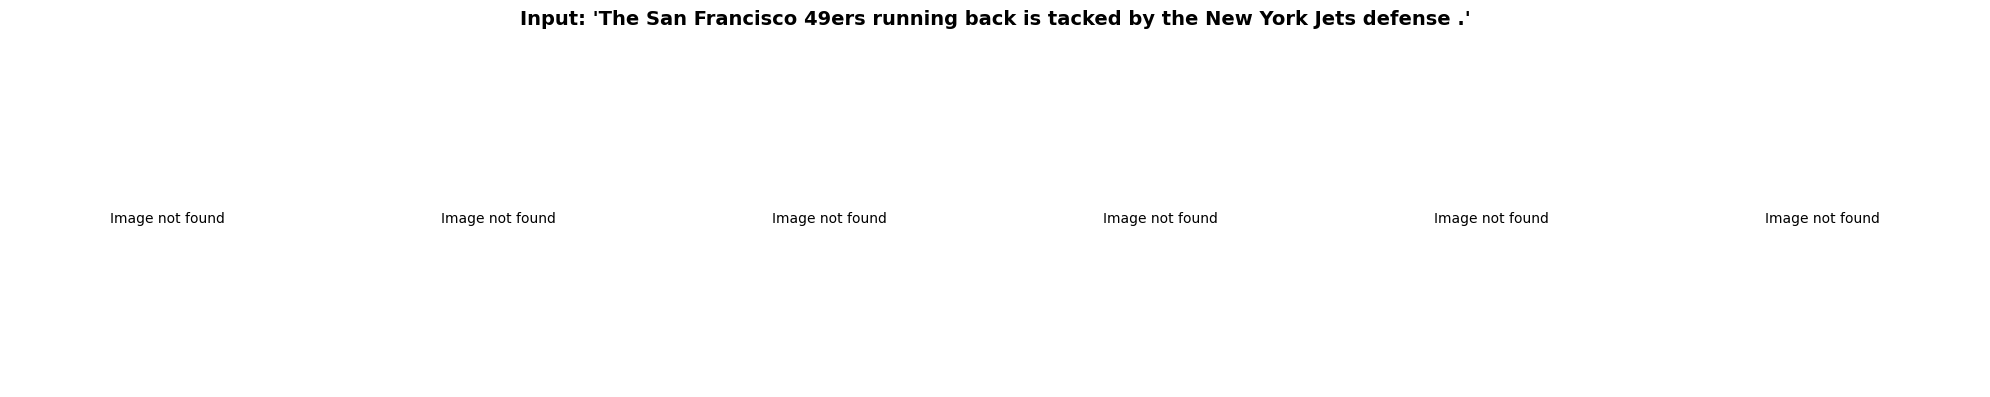

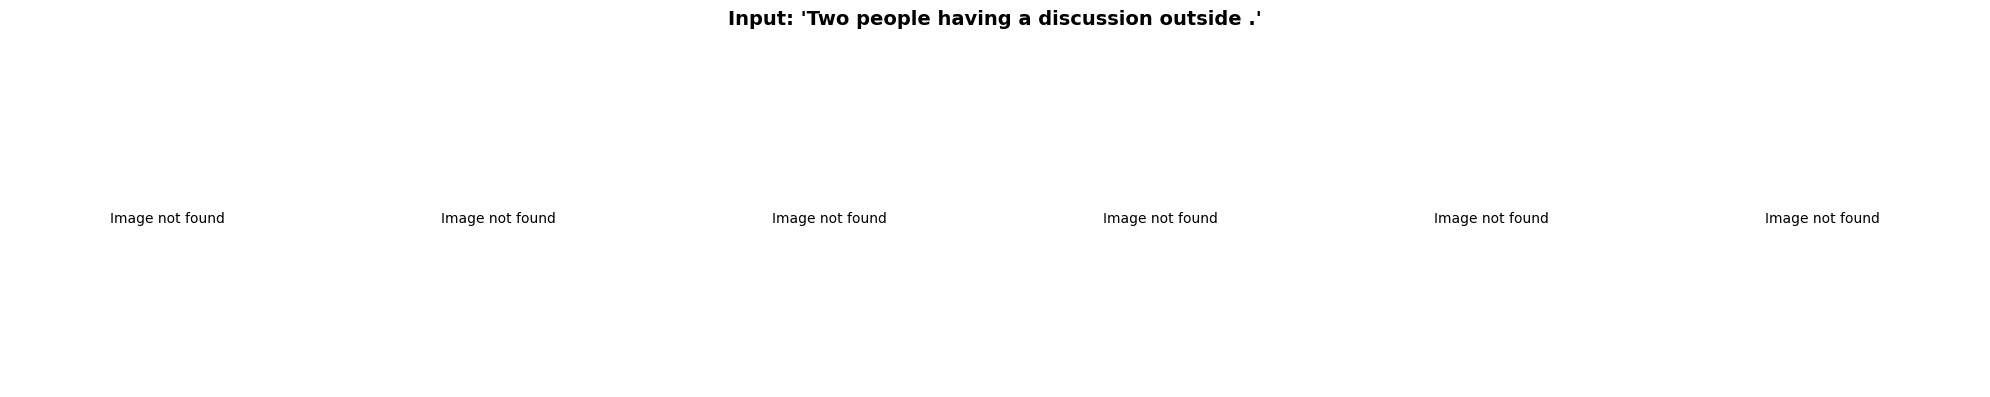

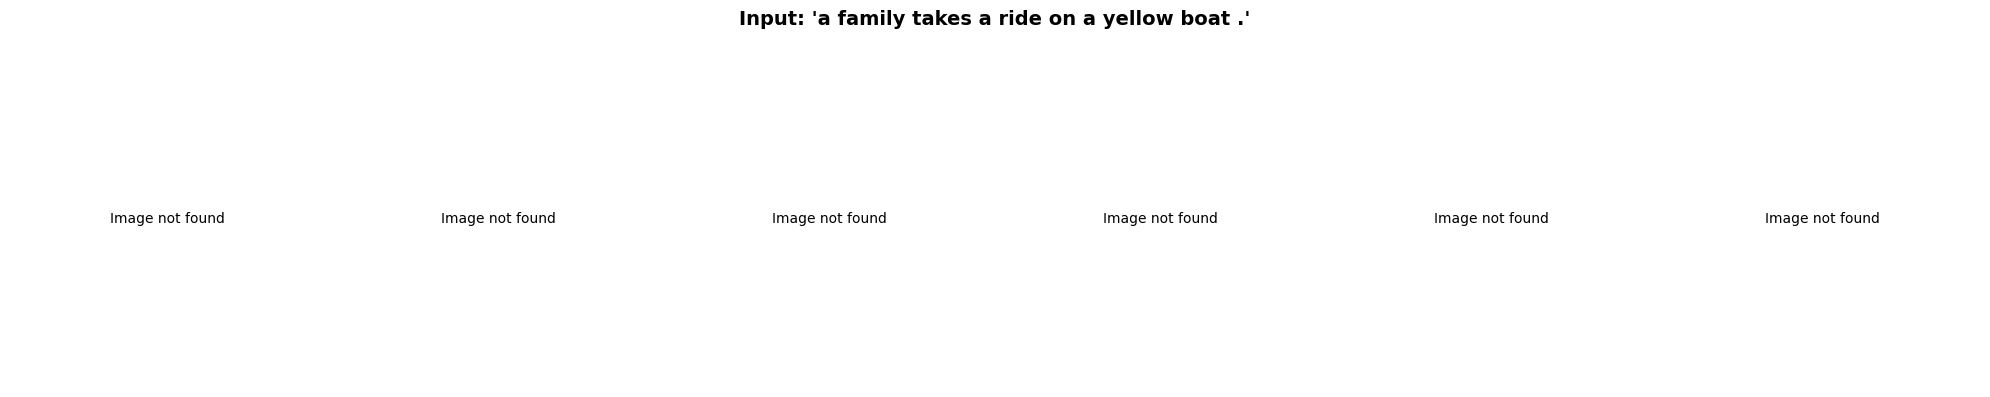

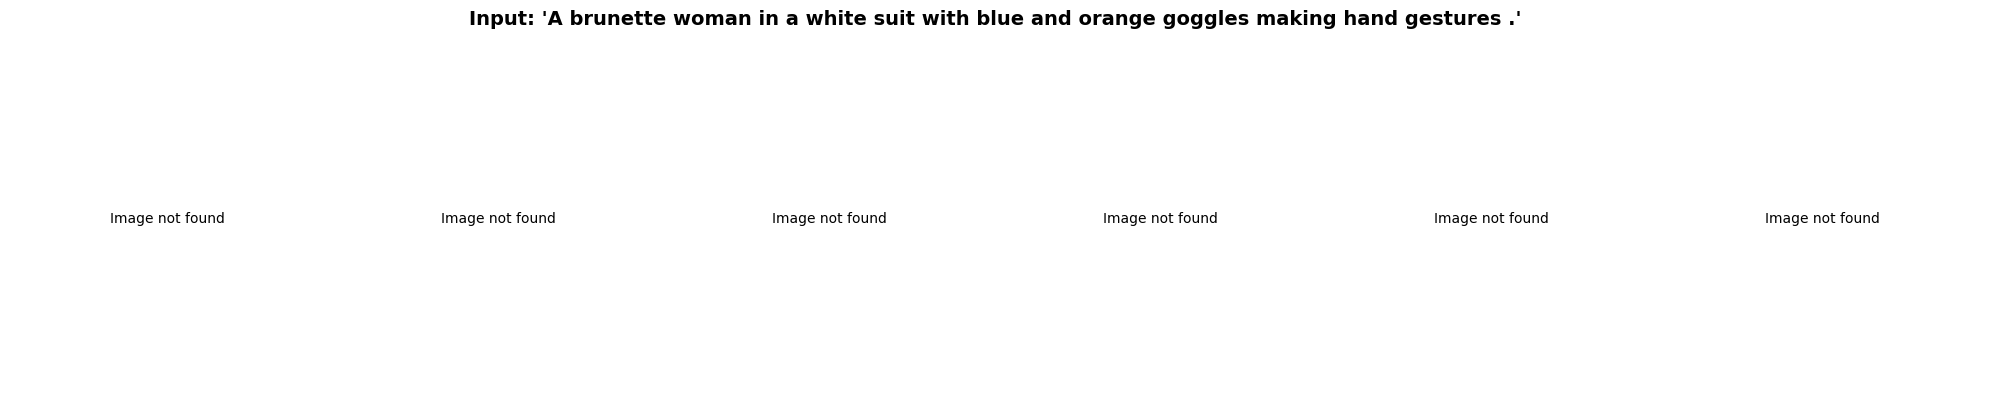

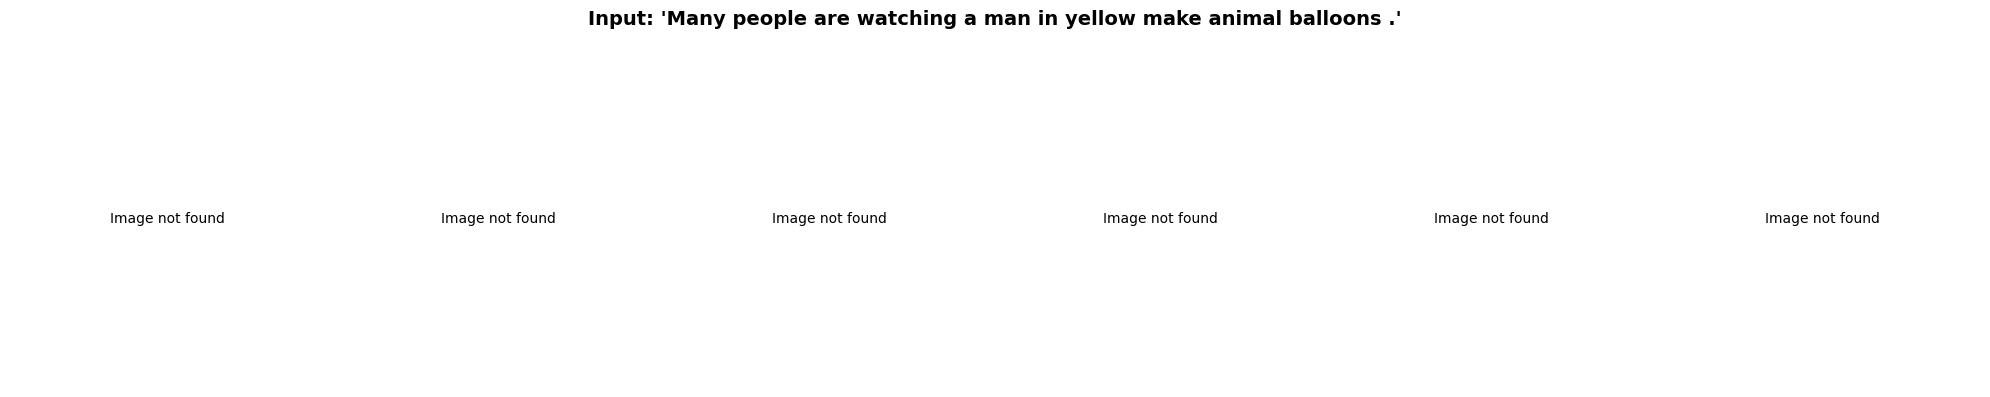

In [13]:
from challenge.src.eval import visualize_retrieval
import numpy as np
import torch

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

In [ ]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")